# Imports

In [1]:
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import scipy

In [2]:
from Functions import get_quantile_groups, bool_from_index, name_from_index, sigmoid, zscore, get_ages_cols

## Directories etc.

In [3]:
data_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta"
ages_cols = get_ages_cols()

data_save_path = os.path.join(data_path, "all_data")
if not os.path.exists(data_save_path):
    os.makedirs(data_save_path)

plot_save_path = "C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots"
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

## Get data

In [4]:
# bf_old = pd.read_csv(os.path.join(data_path, "BUTTERFLY.csv"))
# bf_old = bf_old[['id'] +
#         ['acc{}'.format(i) for i in range(1, 5)] +
#         ['rtavg{}'.format(i) for i in range(1, 5)] +
#         ['rtstd{}'.format(i) for i in range(1, 5)] +
#         ['A', 'NA', 'B', 'F']]
# bf_old = bf_old.rename(columns={'A': 'alpha', 'NA': 'nalpha', 'B': 'beta', 'F': 'forget'})
# bf_old = bf_old.rename(columns={'acc{}'.format(i): 'ACC{}'.format(i) for i in range (1, 5)})
# bf_old = bf_old.rename(columns={'rtavg{}'.format(i): 'RT{}'.format(i) for i in range (1, 5)})
# bf_old = bf_old.rename(columns={'rtstd{}'.format(i): 'RTsd{}'.format(i) for i in range (1, 5)})
# for col in ['RT{}'.format(i) for i in range (1, 5)] + ['RTsd{}'.format(i) for i in range (1, 5)]:
#     bf_old[col] /= 1000
# bf_params = bf_old[['id', 'alpha', 'nalpha', 'beta', 'forget']]
# bf_params

BUTTERFLY.csv
NaN indicates missing data
Columns1-8 (A-H): demographic information
-id: subject id
-group: 1 = 8-12 = kid, 2 = 13-17 = teen, 3 = 18-25 = RPP, 4 = 25-30 = adult
-age: age
-sex: 1 = male, 2 = female
-PDS: PDS-T1: T1-T3: T3-T4: T4
Columns 9-12 (I-L): average accuracy per block (total 120 trials, 30 trials per block)
-accX indicates accuracy in block X
Columns13-20 (M-T): average and standard deviation of reaction time per block
-rtavgX: mean RTfor block X
-rtstdX: standarddeviation of RT for block X
Columns 21-24(U-X): fit model parameters for the winning model so far (AABF)
-A:alpha positive (learning rate for positive RPE)
-NA: alpha negative
-B: beta
-F: forgetting

I used this functional form:
1:53
0.5 + b * exp(-c) - b * exp(-c*x)
1:53
x is trial number (so, 1, 2, ... 30)
1:54
the "0.5 + b * exp(-c)" part is to make sure that on trial 1, the curve starts at 0.5
1:54
It's also the asymptotic performance
1:55
So I will include the asymptotic performance, b and c for you.

ButterflyAdditional.csv

NaN indicates missing data

Column 1 (A): subject id (now there are only 264 subjects instead of 275)
- For other demographic information, see BUTTERFLY.csv

Columns 2-5 (B-E): performance (standard is correct choices, not rewarded choices)
- acc: overall accuracy
- acc1, 2, 3: early, middle, late accuracy

Columns 6-10 (F-J): reaction time (only correct trials are considered)
- rt: overall reaction time
- rt1, 2, 3: early, middle, late reaction time
- rt_sd: overall RT variability

Columns 11-12 (K-L): stay behavior
- stay_choice: stimulus dependent (with respect to last time seeing the same butterfly)
- stay_motor: stimulus independent (with respect to immediately previous trial)

Columns 13-14 (M-N): WSLS
- ws: win_stay / (win_stay + win_shift)
- ls: lose_shift / (lose_stay + lose_shift)

Columns 15 (O): proportion of missing trials (not considering incomplete trials; e.g. if a  participant only finished 60 out of all 120 trials, we only consider proportion of missing trials among those 60 trials)

Columns 16 (P): average performance for the first 3 trials of each butterfly

Columns 17-18 (Q-R): exponential fit to the learning curve of each subject. The functional form of the exponential curve is: 0.5 + a – a * exp(-c * (t - 1)), t is trial number. a is bounded between [0, 0.5], c > 0.
- asymptote: 0.5 + a – a * exp(-c * (T - 1)), where T is total number of trials completed by the subject
- slope: log(c)

Columns 19-21 (S-U): hierarchical regression to predict correct probability on each trial. The regression formula is p(correct) ~ 1 + prew + delay + (1 + prew + delay | id), where ( _ | id) indicates random effects by subject id.
- intercept: random intercept for each subject
- prew: random slope for reward history (number of correct trials for the butterfly, zscored)
- delay: random slope for delay (number of trials since last time seeing the same butterfly and choosing the correct flower, zscored)


In [5]:
bf_params = pd.read_csv(os.path.join(data_path, 'Butterfly_A0BF.csv'))
bf_params = bf_params.rename(columns={'alpha_positive': 'alpha'})
bf_params

,id,alpha,beta,forget
0,17,0.126558,9.675616,0.119638
1,18,0.170546,10.544875,0.028187
2,20,0.213005,11.027134,0.037846
3,22,0.175447,9.853107,0.062803
4,23,0.237062,8.711369,0.024200
...,...,...,...,...
259,465,0.158790,9.737880,0.047585
260,466,0.336139,10.350554,0.112759
261,467,0.207436,9.924361,0.076098
262,468,0.243819,10.294359,0.112742


In [6]:
bf = pd.read_csv(os.path.join(data_path, "ButterflyAdditional.csv"))
bf = pd.merge(bf, bf_params, on='id')

# Add 1/beta
bf['1_over_beta'] = 1 / bf['beta']
bf = bf.drop(columns=('beta'))

# Rename columns
bf = bf.rename(columns={'acc{}'.format(i+1): 'ACC_{}'.format(t) for i, t in enumerate(('early', 'mid', 'late'))})
bf = bf.rename(columns={'early_performance': 'ACC_first3trials'})
bf = bf.rename(columns={'rt{}'.format(i+1): 'RT_{}'.format(t) for i, t in enumerate(('early', 'mid', 'late'))})
bf = bf.rename(columns={'acc': 'ACC', 'rt': 'RT', 'rt_sd': 'RTsd'})
bf = bf.rename(columns={'ws': 'WS', 'ls': 'LS'})
bf = bf.rename(columns={'slope': 'learning_slope'})

# Code lose-shift as lose-stay instead
bf.LS = 1 - bf.LS

# Missing data
bf.loc[np.isnan(bf.ACC_late), 'ACC_late'] = np.mean(bf.ACC_late)
bf.loc[np.isnan(bf.RT_late), 'RT_late'] = np.mean(bf.RT_late)

# Get RTs in seconds
for col in [col for col in bf.columns if 'RT' in col]:
    bf[col] /= 1000
    
# Add "bf_" to each column
bf = bf.rename(columns={col: 'bf_{}'.format(col) for col in bf.columns})
bf

,bf_id,bf_ACC,bf_ACC_early,bf_ACC_mid,bf_ACC_late,bf_RT,bf_RT_early,bf_RT_mid,bf_RT_late,bf_RTsd,...,bf_miss,bf_ACC_first3trials,bf_asymptote,bf_learning_slope,bf_intercept,bf_prew,bf_delay,bf_alpha,bf_forget,bf_1_over_beta
0,17,0.56667,0.650,0.725,0.325,1.33950,1.27260,1.33780,1.47720,0.69630,...,0.0,0.333333,0.59077,-0.053115,0.255267,-0.318745,-0.108595,0.126558,0.119638,0.103353
1,18,0.80000,0.575,0.875,0.950,1.19270,1.13960,1.22100,1.19880,0.53170,...,0.0,0.250000,0.96463,-2.393200,1.930379,1.195528,-0.120319,0.170546,0.028187,0.094833
2,20,0.85000,0.675,0.900,0.975,0.99265,1.16290,1.02430,0.84556,0.52117,...,0.0,0.500000,0.98363,-2.137900,2.352541,1.329053,-0.168739,0.213005,0.037846,0.090685
3,22,0.73333,0.600,0.825,0.775,1.51800,1.56260,1.42940,1.57780,1.03220,...,0.0,0.416667,0.82375,-1.937400,1.152193,0.528728,-0.163958,0.175447,0.062803,0.101491
4,23,0.81667,0.725,0.875,0.850,1.62240,1.55680,1.81620,1.47890,0.85927,...,0.0,0.666667,0.88317,-1.730200,1.548147,0.690841,-0.190590,0.237062,0.024200,0.114793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,465,0.74167,0.575,0.800,0.850,1.11640,1.37600,1.06800,0.98635,0.52359,...,0.0,0.666667,0.75862,3.626000,1.238689,0.644662,-0.135437,0.158790,0.047585,0.102692
260,466,0.60833,0.550,0.700,0.575,0.87618,0.88236,0.97296,0.75243,0.32142,...,0.0,0.583333,0.63033,-1.718600,0.566666,0.213814,-0.238006,0.336139,0.112759,0.096613
261,467,0.80000,0.825,0.800,0.775,1.29200,1.58270,1.08610,1.19510,0.83115,...,0.0,0.750000,0.80872,-0.662550,1.276838,0.174681,-0.118256,0.207436,0.076098,0.100762
262,468,0.71667,0.700,0.775,0.675,2.12680,2.32480,2.46370,1.53470,1.53770,...,0.0,0.500000,0.73918,-0.539960,0.941660,0.174725,-0.110450,0.243819,0.112742,0.097141


In [7]:
fc = pd.read_csv(os.path.join(data_path, "4choice.csv"))

# Wanted columns
fc = fc[['pID', 'pers', 'persER', 'discER', 'revER', 'irrel', 'novel', 'novelER', 'discTTC', 'revTTC', 'trial1visits',
         'cor1visits', 'prerevvisits', 'revvisits', 'revcor1visits', 'lastvisits', 'novelvisits', 'meanRT', 'discRT',
         'revRT', 'stdRT', 'RTvsTOT'] + ['betas_{}'.format(i) for i in range(1, 5)] + ['alpha', 'beta', 'ralpha']]

# Recode errors as accuracy
fc = fc.rename(columns={'persER': 'ACCpers', 'discER': 'ACCdisc', 'novelER': 'ACCnovel'})
for col in ['ACCpers', 'ACCdisc', 'ACCnovel']:
    fc[col] = 1 - fc[col]

# Rename columns
fc = fc.rename(columns={'meanRT': 'RT', 'discRT': 'RTdisc', 'revRT': 'RTrev', 'stdRT': 'RTsd'})
fc = fc.rename(columns={col: 'fc_{}'.format(col) for col in fc.columns})
fc

,fc_pID,fc_pers,fc_ACCpers,fc_ACCdisc,fc_revER,fc_irrel,fc_novel,fc_ACCnovel,fc_discTTC,fc_revTTC,...,fc_RTrev,fc_RTsd,fc_RTvsTOT,fc_betas_1,fc_betas_2,fc_betas_3,fc_betas_4,fc_alpha,fc_beta,fc_ralpha
0,17,1,0.666667,0.320000,0.375000,1,1,0.666667,25,8,...,5.166875,6.252144,19.867000,-0.747755,2.393145,-1.200283,-0.876754,0.003477,0.999985,0.772359
1,18,2,0.333333,1.000000,0.375000,0,1,0.666667,5,8,...,11.596125,3.446076,1.233000,1.024505,0.003234,-0.411955,0.526157,0.518217,0.880084,0.734655
2,19,2,0.333333,0.833333,0.375000,0,1,0.666667,6,8,...,4.342000,5.025114,3.767000,1.152230,0.287367,-0.397495,0.452434,0.705434,0.054487,0.602075
3,20,6,0.538462,0.666667,0.722222,3,4,0.692308,9,18,...,9.277278,4.581754,3.151000,-0.561582,2.062041,-2.808764,0.933507,0.272261,0.041704,0.260541
4,22,1,0.666667,0.555556,0.375000,1,1,0.666667,9,8,...,6.441875,5.563094,0.733000,0.728011,0.921913,-0.387658,0.317687,0.140372,0.295324,0.999997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,485,2,0.500000,0.600000,0.444444,1,1,0.750000,10,9,...,5.018651,1.722870,0.933190,0.668700,0.867902,-0.777079,1.150747,NaN,NaN,NaN
228,486,3,0.571429,0.625000,0.583333,2,2,0.714286,8,12,...,4.111255,3.054055,4.733422,0.281346,1.992270,-2.590093,1.709546,NaN,NaN,NaN
229,487,2,0.333333,0.625000,0.375000,0,1,0.666667,8,8,...,2.416839,1.485993,3.166378,1.385322,-0.207979,2.075924,2.386833,NaN,NaN,NaN
230,488,1,0.500000,0.555556,0.285714,0,1,0.500000,9,7,...,6.062182,4.295897,3.200090,1.217302,1.716272,-1.354100,-1.143206,NaN,NaN,NaN


discER is the error rate (errors/trials) for the discrimination (first) phase. revER is the percentage error rate (errors/trials) for the reversal phase. 

Pers is the number of perseveration errors they made in the reversal phase, while persER is the percentage of total reversal phase errors that were perseveration errors (# perseveration errors/# reversal trials). The same goes for novel and novelER. Irrel is the number of irrelevant errors they made in reversal (so, not picking the novel box, and not perseverating on the correct box from the discrimination phase). 

discTTC is the number of trials they took to reach criterion on the discrimination phase; revTTC is the same in the reversal phase. So irrel + novel + pers should = revTTC. 

Trial1visits is how many different boxes they walk up to on the first trial of the entire task (1st trial of discrimination phase). Cor1visits is how many different boxes they walk up to after they have gotten their first star (so, correctly identified the box that they should continue to pick). 

Prerevvisits is how many boxes they walk up to on the last trial before the reversal. Revvisits is how many boxes they walk up to on the first reversal trial (but before they know that a reversal has even happened). These two numbers should be very similar. 

Revcor1visits is how many boxes they walk up to once they've realized that a reversal has taken place. This should go up a little.

Lastvisits is how many boxes they go up to on the last trial of the task (should be low if they've learned the correct reversal box).  

Novel visits is how many times in TOTAL they approach the completely new box during the reversal phase.

The labels persist for the RT columns: mean RT is self-explanatory, then it's the discrimination RT, then it's the reversal RT, then it's the standard deviation of each subjects' RTs. 

RTvsTOT is a measure of how the RT's changed over the course of the task. So it's the RT from trial 2 versus the RT from the very last trial. Last trial should be faster so the number should be positive, unless the subject is impulsive.

The regression I ran was a logistic regression subject-by-subject, predicting trial-by-trial accuracy (1 or 0). Betas_1 is the effect of cumulative previous correct trials. Betas_2 is the effect of delay since last correct trial. Betas_3 is the effect of reversal, and Betas_4 is the effect of boxes visited on that trial (walked up to but not selected). I ran an iteration with previous INcorrect trials when we found that that had some weird negative effect on accuracy in our other SLCN tasks... But that's the not the version here, I don't think.

Betas_1 through _4 are logistic regression betas with correct/incorrect as the predicted variable and things like previous number of correct trials as predictor. I don't remember now what went into that, but I can clarify if I can see the code again.

alpha is the estimated discrimination phase learning rate from a simple RL model with a separate alpha for the disc and reversal phases. beta is the softmax inverse temperature parameter. ralpha is the separate reversal phase learning rate. Amy will know all about these since I basically just ran her thesis code to obtain these parameters. :) These estimates were obtained in a non-hierarchical fashion, and some of these subjects have only 12 trials, so I wouldn't be too sure about them. I do think Anne ran some hierarchical versions of this modeling, though I don't remember where those numbers went, though I think they were unexciting.

PDS is pubertal development score (which I'm sure you know), Period_age is age of first periods for girls and adult women. Gender is 1 for males, 2 for females. And columbia is the puberty category (1-3) that they would have been assigned to using the criteria Michelle van Tieghem used at Columbia for her 4choice dataset.

In [8]:
rlwm = pd.read_csv(os.path.join(data_path, "RLWM.csv"))
rlwm.columns

Index(['IDs', 'lrn-fix', 'lrn-ns', 'lrn-delay', 'lrn-pcor', 'lrn-pinc',
       'allns-allt', 'allns-ely', 'allns-lat', 'ns2-allt', 'ns2-ely',
       'ns2-lat', 'ns3-allt', 'ns3-ely', 'ns3-lat', 'ns4-allt', 'ns4-ely',
       'ns4-lat', 'ns5-allt', 'ns5-ely', 'ns5-lat', 'allns-rt_allt',
       'allns-rt_ely', 'allns-rt_lat', 'ns2-rt_allt', 'ns2-rt_ely',
       'ns2-rt_lat', 'ns3-rt_allt', 'ns3-rt_ely', 'ns3-rt_lat', 'ns4-rt_allt',
       'ns4-rt_ely', 'ns4-rt_lat', 'ns5-rt_allt', 'ns5-rt_ely', 'ns5-rt_lat',
       'allns-rtstd_allt', 'allns-rtstd_ely', 'allns-rtstd_lat',
       'ns2-rtstd_allt', 'ns2-rtstd_ely', 'ns2-rtstd_lat', 'ns3-rtstd_allt',
       'ns3-rtstd_ely', 'ns3-rtstd_lat', 'ns4-rtstd_allt', 'ns4-rtstd_ely',
       'ns4-rtstd_lat', 'ns5-rtstd_allt', 'ns5-rtstd_ely', 'ns5-rtstd_lat',
       'allns-motorstay', 'ns2-motorstay', 'ns3-motorstay', 'ns4-motorstay',
       'ns5-motorstay', 'allns-WS', 'allns-LS', 'ns2-WS', 'ns2-LS', 'ns3-WS',
       'ns3-LS', 'ns4-WS', 'ns4-LS', 'ns

In [9]:
sub = rlwm.loc[np.invert(np.isnan(rlwm.IDs)), ['IDs', 'ns2-allt', 'ns3-allt', 'ns4-allt', 'ns5-allt']]
sub['slope'] = 3 * sub['ns5-allt'] + sub['ns4-allt'] - sub['ns3-allt'] - 3 * sub['ns2-allt']
sub

,IDs,ns2-allt,ns3-allt,ns4-allt,ns5-allt,slope
10,11.0,0.79592,0.72414,0.70588,0.69444,-0.32270
12,13.0,0.92000,0.79825,0.78000,0.65263,-0.82036
15,16.0,0.92308,0.82051,0.78846,0.81026,-0.37051
16,17.0,0.90385,0.88793,0.87500,0.78866,-0.35850
17,18.0,0.92308,0.89744,0.90385,0.84615,-0.22438
...,...,...,...,...,...,...
464,465.0,0.82692,0.92308,0.81731,0.84615,-0.04808
465,466.0,0.94231,0.90598,0.89423,0.87179,-0.22331
466,467.0,0.84615,0.88889,0.81731,0.88205,0.03612
467,468.0,0.84615,0.92308,0.91346,0.83505,-0.04292


In [10]:
def get_rlwm_ns_contrast(rlwm, cols):
    
    return -3 * rlwm[cols['ns5']] - rlwm[cols['ns4']] + rlwm[cols['ns3']] + 3 * rlwm[cols['ns2']]  # linear contrast

# # Example use
# rlwm = pd.read_csv(os.path.join(data_path, "RLWM.csv"))
# cols = {'ns{}'.format(i): 'ns{}-allt'.format(i) for i in range(2, 6)}
# get_rlwm_ns_contrast(rlwm, cols)

Adding column lrn_fix_sig_sig.
Adding column lrn_delay_sig_sig.
Adding column lrn_ns_sig_sig.
Adding column lrn_pcor_sig_sig.
Adding column lrn_pinc_sig_sig.
             pers    RL alpha      nalpha  log_nalpha
count  300.000000  300.000000  300.000000  300.000000
mean     0.709621    0.057603    0.027983   -5.441763
std      0.272797    0.164496    0.120256    1.772285
min      0.001000    0.002362    0.000004  -12.316111
25%      0.666718    0.013831    0.001795   -6.322936
50%      0.801421    0.019999    0.003694   -5.600953
75%      0.882997    0.033839    0.009914   -4.614078
max      0.999000    1.000000    0.998000   -0.002002


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log


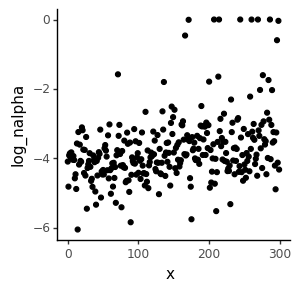

<ggplot: (116677559724)>


Index(['rl_IDs', 'rl_ACC', 'rl_ACC_early', 'rl_ACC_late', 'rl_ACC_ns2',
       'rl_ACC_early_ns2', 'rl_ACC_late_ns2', 'rl_ACC_ns3', 'rl_ACC_early_ns3',
       'rl_ACC_late_ns3', 'rl_ACC_ns4', 'rl_ACC_early_ns4', 'rl_ACC_late_ns4',
       'rl_ACC_ns5', 'rl_ACC_early_ns5', 'rl_ACC_late_ns5', 'rl_RT',
       'rl_RT_early', 'rl_RT_late', 'rl_RT_ns2', 'rl_RT_early_ns2',
       'rl_RT_late_ns2', 'rl_RT_ns3', 'rl_RT_early_ns3', 'rl_RT_late_ns3',
       'rl_RT_ns4', 'rl_RT_early_ns4', 'rl_RT_late_ns4', 'rl_RT_ns5',
       'rl_RT_early_ns5', 'rl_RT_late_ns5', 'rl_RTsd', 'rl_allns-rtstd_ely',
       'rl_allns-rtstd_lat', 'rl_RTsd_ns2', 'rl_ns2-rtstd_ely',
       'rl_ns2-rtstd_lat', 'rl_RTsd_ns3', 'rl_ns3-rtstd_ely',
       'rl_ns3-rtstd_lat', 'rl_RTsd_ns4', 'rl_ns4-rtstd_ely',
       'rl_ns4-rtstd_lat', 'rl_RTsd_ns5', 'rl_ns5-rtstd_ely',
       'rl_ns5-rtstd_lat', 'rl_stay_motor', 'rl_ns2-motorstay',
       'rl_ns3-motorstay', 'rl_ns4-motorstay', 'rl_ns5-motorstay', 'rl_WS',
       'rl_LS', 'rl_

In [11]:
rlwm = pd.read_csv(os.path.join(data_path, "RLWM.csv"))
rlwm = rlwm.dropna(subset=['IDs'])  # remove empty rows

# Add slope over set sizes
rlwm['ACC_ns_slope'] = get_rlwm_ns_contrast(rlwm, {'ns{}'.format(i): 'ns{}-allt'.format(i) for i in range(2, 6)})
rlwm['RT_ns_slope'] = -get_rlwm_ns_contrast(rlwm, {'ns{}'.format(i): 'ns{}-rt_allt'.format(i) for i in range(2, 6)})
rlwm['ACC_ns_slope_delta'] = (
    get_rlwm_ns_contrast(rlwm, {'ns{}'.format(i): 'ns{}-lat'.format(i) for i in range(2, 6)}) -
    get_rlwm_ns_contrast(rlwm, {'ns{}'.format(i): 'ns{}-ely'.format(i) for i in range(2, 6)})
)
rlwm['RT_ns_slope_delta'] = (  # don't need to switch order and don't need to take the negative of get_rlwm_ns_contrast because they cancel each other out [-b --a == a - b]
    get_rlwm_ns_contrast(rlwm, {'ns{}'.format(i): 'ns{}-rt_lat'.format(i) for i in range(2, 6)}) -
    get_rlwm_ns_contrast(rlwm, {'ns{}'.format(i): 'ns{}-rt_ely'.format(i) for i in range(2, 6)})
)

# Sigmoid transform regression results
sig_cols = ['lrn-fix', 'lrn-delay', 'lrn-ns', 'lrn-pcor', 'lrn-pinc']
for col in sig_cols:
    new_col_name = '_'.join(col.split('-')) + '_sig'
    print("Adding column {}_sig.".format(new_col_name))
    rlwm[new_col_name] = sigmoid(rlwm[col])
rlwm = rlwm.drop(columns=sig_cols)
# (gg.ggplot(rlwm, gg.aes('IDs', 'lrn_fix_sig'))
#  + gg.geom_point(color='red')
#  + gg.geom_smooth(color='red')
#  + gg.geom_point(gg.aes(y='lrn_ns_sig'), color='blue')
#  + gg.geom_smooth(gg.aes(y='lrn_ns_sig'), color='blue')
#  + gg.geom_point(gg.aes(y='lrn_pcor_sig'), color='green')
#  + gg.geom_smooth(gg.aes(y='lrn_pcor_sig'), color='green')
#  + gg.geom_point(gg.aes(y='lrn_pinc_sig'), color='pink')
#  + gg.geom_smooth(gg.aes(y='lrn_pinc_sig'), color='pink')
#  + gg.geom_point(gg.aes(y='lrn_delay_sig'), color='grey')
#  + gg.geom_smooth(gg.aes(y='lrn_delay_sig'), color='grey')
# )

# Deal withparticipant 328: They have perfect performance after the first correct choice,
# which means that the logistic regression is trying to predict a vector of 1's (and can't be fit).
# It doesn't make sense to exclude them because of a perfect performance.
# but not clear how to put them in either - a hierarchical regression would have helped with that...
# idea 1) - put effects to values that make sense: 0 for all regressors (no effects of set size, delay,
# pcor, pinc on their performance), and maximum value for fixed effect.
rlwm.loc[
    np.isnan(rlwm['lrn_ns_sig']),
    ['lrn_fix_sig', 'lrn_delay_sig', 'lrn_ns_sig', 'lrn_pcor_sig', 'lrn_pinc_sig']
] = [1, 0, 0, 0, 0]
# Two participants (19 and 74) are missing data for ns2-lose-shift. => might have shown no trials in which they
# lost and didn't switch in set size 2 => set ns2-lose-shift to 1.
rlwm.loc[np.isnan(rlwm['ns2-LS']), 'ns2-LS'] = 1

# Add better parameters
# rlwm['1_over_epsilon_beta'] = 1 / rlwm['epsilon']
rlwm['log_alpha'] = np.log(rlwm['RL alpha'])
rlwm['log_nalpha'] = np.log((1 - rlwm['pers']) * rlwm['RL alpha'])
rlwm['pers'] = 0.001 + 0.998 * rlwm['pers']
rlwm['nalpha'] = (1 - rlwm['pers']) * rlwm['RL alpha']
# rlwm['nalpha'] = 0.001 + 0.998 * rlwm['nalpha']
rlwm['log_nalpha'] = np.log(rlwm['nalpha'])
print(rlwm[['pers', 'RL alpha', 'nalpha', 'log_nalpha']].describe())

plot_dat = pd.DataFrame({'x': np.arange(len(rlwm['log_alpha'])), 'log_nalpha': rlwm['log_alpha']})
gg.options.figure_size = (3, 3)
print(gg.ggplot(plot_dat, gg.aes('x', "log_nalpha"))
          + gg.geom_point()
         )

# Rename
rlwm = rlwm.rename(columns={'ns{}-ely'.format(i): 'ACC_early_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-lat'.format(i): 'ACC_late_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-allt'.format(i): 'ACC_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-rt_ely'.format(i): 'RT_early_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-rt_lat'.format(i): 'RT_late_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-rt_allt'.format(i): 'RT_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-rtstd_allt'.format(i): 'RTsd_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'allns-allt': 'ACC', 'allns-ely': 'ACC_early', 'allns-lat': 'ACC_late'})
rlwm = rlwm.rename(columns={'allns-rt_allt': 'RT', 'allns-rt_ely': 'RT_early', 'allns-rt_lat': 'RT_late', 'allns-rtstd_allt': 'RTsd'})
rlwm = rlwm.rename(columns={'allns-motorstay': 'stay_motor', 'allns-choicestay': 'stay_choice', 'allns-WS': 'WS', 'allns-LS': 'LS'})
rlwm = rlwm.rename(columns={'pers': 'persev', 'WM phi': 'forget', 'WM rho': 'rho', 'epsilon': 'epsilon_1_over_beta'})
rlwm = rlwm.rename(columns={'missing': 'miss'})

# Code lose-shift as lose-stay instead
rlwm.LS = 1 - rlwm.LS
rlwm['lrn_pinc_sig'] = 1 - rlwm['lrn_pinc_sig']  # lrn-pinc: effect of number of previous incorrect trials; orient in same direction as other measures of LS
rlwm['lrn_ns_sig'] = 1 - rlwm['lrn_ns_sig']  # code in same direction as ACC_ns_slope and RT_ns_slope (larger numbers = better performance in SMALLER set sizes; right now numbers are negative)

# print(rlwm.columns)

# # Select columns
# rlwm = rlwm[['IDs', 'lrn_fix_sig', 'lrn_ns_sig', 'lrn_delay_sig', 'lrn_pcor_sig', 'lrn_pinc_sig'] +
#              ['ACC_early_ns{}'.format(i) for i in range(2, 6)] +   # ACC early per set size
#              ['ACC_late_ns{}'.format(i) for i in range(2, 6)] +    # ACC late per set size
#              ['ACC_ns{}'.format(i) for i in range(2, 6)] +         # ACC overall per set size
#              ['ACC', 'ACC_early', 'ACC_late'] +                    # ACC overall overall
#              ['RT_early_ns{}'.format(i) for i in range(2, 6)] +    # RT early per set size
#              ['RT_late_ns{}'.format(i) for i in range(2, 6)] +     # RT late per set size
#              ['RT_ns{}'.format(i) for i in range(2, 6)] +          # RT overall per set size
#              ['RT', 'RT_early', 'RT_late'] +                       # RT overall
#              ['WS', 'LS', 'stay_motor', 'stay_choice', 'RTsd', 'miss'] +
#              ['log_alpha', 'log_nalpha', 'forget', 'rho', 'epsilon_1_over_beta', 'K']#, 'nsslope', 'overall']]
#            ]

# # Add columns
# rlwm['ACC_ns2_minus_ns5'] = rlwm['ACC_ns2'] - rlwm['ACC_ns5']
# rlwm['ACC_ns2_minus_ns5_early'] = rlwm['ACC_early_ns2'] - rlwm['ACC_early_ns5']
# rlwm['ACC_ns2_minus_ns5_late'] = rlwm['ACC_late_ns2'] - rlwm['ACC_late_ns5']
# rlwm['ACC_ns2_minus_ns5_delta'] = rlwm['ACC_ns2_minus_ns5_late'] - rlwm['ACC_ns2_minus_ns5_early']
# rlwm['RT_ns5_minus_ns2'] = rlwm['RT_ns5'] - rlwm['RT_ns2']

# Note about nsslope: not present for undergrads (IDs in the 400's), so I would have to exclude too many subjects
# rlwm_v02 = pd.read_csv(os.path.join(data_path, "RLWM_v02.csv"))
# rlwm_v02 = rlwm_v02.dropna(subset=['IDs'])
# rlwm = pd.merge(rlwm, rlwm_v02[['IDs', 'nsslope']], on='IDs', )

rlwm = rlwm.rename(columns={col: 'rl_{}'.format(col) for col in rlwm.columns})
rlwm.columns

* Column 1: participant ID. nan if no data
* Columns 2-6 (A-F): logistic regression weights
    * lrn-fix: fixed effect
    * lrn-ns: set size effect
    * lrn-delay: delay effect
    * lrn-pcor: effect of number of previous correct trials
    * lrn-pinc: effect of number of previous incorrect trials
* Columns 7:15 (G-N): proportion of correct trials; nsX indicates set size
    * -ely: early trials (1-3 for each stim)
    * lat: late trials (last three for each stim)
* Columns 16-22 (O-V): correct RT
    * rtavg: mean RT
    * rtstd: std(RT)
    * nsX indicates set size
* Columns 23-28 (W-AB): fit model parameters
    * K capacity
    * RL alpha : learning rate
    * WM rho: WM weight
    * WM phi: forgetting
    * epsilon: noise
    * pers: perseveration

In [12]:
ps = pd.read_csv(os.path.join(data_path, "ProbSwitch.csv"), index_col=0)

# Add 1 / beta columns
ps['1_over_beta_rl'] = 1 / ps['beta_RL']
ps['1_over_beta_bf'] = 1 / ps['beta_BF']
ps['1_over_beta'] = (ps['1_over_beta_rl'] + ps['1_over_beta_bf']) / 2
ps['persev'] = (ps['persev_RL'] + ps['persev_RL']) / 2
ps = ps.drop(columns=['persev_RL', 'persev_BF', '1_over_beta_rl', '1_over_beta_bf'])
ps = ps.drop(columns=['calpha', 'cnalpha', 'beta_RL', 'beta_BF'])
ps = ps.rename(columns={'percent_missed': 'miss'})

# Get RTs in seconds
for col in ['RT.{}'.format(i) for i in range(1, 4)] + ['RT', 'RTsd']:
    ps[col] /= 1000
    
# Get early, mid, late perf
for col in ['RT', 'ACC']:
    ps = ps.rename(columns={'{}.{}'.format(col, i+1): '{}_{}'.format(col, t) for i, t in enumerate(('early', 'mid', 'late'))})

# Lose-shift is already coded as lose-shift! No switch necessary here!
ps.loc[np.isnan(ps['LWS']), 'LWS'] = np.mean(ps.LWS)  # Replace missing values with group average (~80%)
    
ps = ps.rename(columns={col: 'ps_{}'.format(col) for col in ps.columns})
ps.columns

Index(['ps_sID', 'ps_p_switch', 'ps_p_reward', 'ps_alpha', 'ps_nalpha',
       'ps_ACC', 'ps_stay', 'ps_RTsd', 'ps_RT', 'ps_n_switches',
       'ps_ACC_early', 'ps_stay.1', 'ps_RTsd.1', 'ps_RT_early', 'ps_ACC_mid',
       'ps_stay.2', 'ps_RTsd.2', 'ps_RT_mid', 'ps_ACC_late', 'ps_stay.3',
       'ps_RTsd.3', 'ps_RT_late', 'ps_miss', 'ps_WLS', 'ps_LWS', 'ps_WS',
       'ps_LS', 'ps_criterion_trial', 'ps_1_over_beta', 'ps_persev'],
      dtype='object')

In [13]:
# ps = ps.merge(ages[ages_cols], left_on='ps_sID', right_on='ID')
# ps['age_group'], _ = get_quantile_groups(ps, 'PreciseYrs')
# ps['age_group_'] = pd.Categorical(ps.age_group.replace({0.25: '08-10', 0.5: '10-13', 0.75: '13-15', 1: '15-17', 2: '2Stud.', 3: '3Adult'}), ordered=True)
# ps.shape

In [14]:
# ps.shape, all_data.shape

In [15]:
# (291-247) / 291

In [16]:
# gg.options.figure_size = (1.5, 1.5)
# (gg.ggplot(ps, gg.aes('PreciseYrs', 'ps_persev_rl'))
#  + gg.geom_point()
#  + gg.geom_smooth()
# )
# print(gg.ggplot(ps, gg.aes('age_group_', 'ps_persev_rl', group=1))
#       + gg.stat_summary()
#       + gg.stat_summary(geom='line')
# )
# print(gg.ggplot(all_data, gg.aes('age_group_', 'ps_persev_rl', group=1))
#       + gg.stat_summary()
#       + gg.stat_summary(geom='line')
# )

## Create all_data and all_data_long

In [17]:
bf.shape, fc.shape, rlwm.shape, ps.shape

((264, 24), (232, 29), (300, 85), (291, 30))

In [18]:
bf_ids = np.unique(bf.bf_id)
rl_ids = np.unique(rlwm.rl_IDs)
ps_ids = np.unique(ps.ps_sID)
fc_ids = np.unique(fc.fc_pID)
fc_ids_clean = [id for id in fc.fc_pID if (id < 300) or (id > 400)]

print("Butterfly data (n={}): {}".format(len(bf_ids), bf_ids))
print("RLWM data (n={}): {}".format(len(rl_ids), rl_ids))
print("ProbSwitch data (n={}): {}".format(len(ps_ids), ps_ids))
print("4-choice data (n={}; after excluding Columbia: {}): {}".format(len(fc_ids), len(fc_ids_clean), fc_ids))

Butterfly data (n=264): [ 17  18  20  22  23  24  25  27  28  29  30  31  32  35  36  37  38  40
  42  43  44  46  49  50  51  53  55  56  57  59  60  66  67  68  70  71
  72  73  74  76  77  78  80  81  82  83  85  86  87  90  91  92  93  94
  95  96  97  98  99 100 101 104 105 106 109 110 111 112 113 115 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 135 137 138
 139 140 141 142 144 145 147 148 149 150 151 152 153 154 155 157 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 175 176 177 178 180 181
 182 183 184 185 188 189 190 191 193 194 195 196 198 199 200 201 202 204
 205 208 209 210 212 213 214 215 217 218 219 220 221 300 301 302 303 304
 305 306 308 309 310 311 312 313 314 315 316 317 318 319 320 322 323 325
 326 328 329 330 331 332 333 334 335 337 338 339 342 343 345 347 348 349
 350 351 352 353 354 357 359 360 361 362 363 364 365 409 410 411 412 413
 415 416 417 419 420 421 422 423 424 426 427 428 429 430 431 432 434 435
 436 437 438 439 440 441 44

In [19]:
# Merge all tasks
bf_rlwm = bf.merge(rlwm, left_on='bf_id', right_on='rl_IDs')  # bf + rlwm
# fc_bf_rlwm = fc.merge(bf_rlwm, left_on='fc_pID', right_on='bf_id')  # + fc
# all_data = fc_bf_rlwm.merge(ps, left_on='fc_pID', right_on='ps_sID')  # + ps
all_data = bf_rlwm.merge(ps, left_on='bf_id', right_on='ps_sID')  # + ps
all_data = all_data.rename(columns={'bf_id': 'ID'})
all_data = all_data.drop(columns=['rl_IDs', 'ps_sID'])

In [20]:
def get_delta(data, early_col_name, late_col_name):
    
    performance_improvement = data[late_col_name] - data[early_col_name]
    performance_mean = (data[late_col_name] + data[early_col_name]) / 2
    
    return performance_improvement #* performance_mean

# # Example use
# get_delta(all_data, 'ps_ACC_early', 'ps_ACC_late')
# get_delta(all_data, 'ps_RT_late', 'ps_RT_early')

In [21]:
# Add ages data
ages_dir = "C:/Users/maria/MEGAsync/SLCNdata/SLCNinfo2.csv"
ages = pd.read_csv(os.path.join(ages_dir))
all_data = all_data.merge(ages[['ID', 'PreciseYrs', 'BMI', 'Gender', 'meanT', 'PDS']])

# Get age, PDS, Testost. groups
all_data['sex'] = all_data.Gender.replace({1: 'Male', 2: 'Female'})
all_data['age_group'], _ = get_quantile_groups(all_data, 'PreciseYrs')
all_data['age_group_'] = pd.Categorical(all_data.age_group.replace({0.25: '08-10', 0.5: '10-13', 0.75: '13-15', 1: '15-17', 2: '2Stud.', 3: '3Adult'}), ordered=True)
all_data['T_group'], _ = get_quantile_groups(all_data, 'meanT')
all_data['T_group_'] = pd.Categorical(all_data.T_group.replace({0.25: '0_25%', 0.5: '1_50%', 0.75: '2_75%', 1: '3_100%', 2: '4_Stud.', 3: '5_Adult'}), ordered=True)
all_data['PDS_group'] = np.nan
all_data.loc[all_data['PreciseYrs'] > 17, 'PDS_group'] = all_data.loc[all_data['PreciseYrs'] > 17, 'age_group']  # Get adults
all_data.loc[all_data['PDS'] == 1, 'PDS_group'] = 0  # Get pre-pubertal kids
all_data.loc[all_data['PDS'] > 1, 'PDS_group'], _ = get_quantile_groups(  # Get pubertal teens
    all_data.loc[all_data['PDS'] > 1], 'PDS', quantiles=np.array([0, 1/3, 2/3]))
all_data['PDS_group_'] = pd.Categorical(all_data.PDS_group.replace({0: '0_pre', 0.33: '1_early', 0.67: '2_mid', 1: '3_late', 2: '4_Stud.', 3: '5_Adult'}), ordered=True)

# Add delta columns
for task in ['bf', 'rl', 'ps']:
    all_data['{}_ACC_delta'.format(task)] = get_delta(all_data, '{}_ACC_late'.format(task), '{}_ACC_early'.format(task))
    all_data['{}_RT_delta'.format(task)] = get_delta(all_data, '{}_RT_early'.format(task), '{}_RT_late'.format(task))
#     all_data['{}_ACC_delta'.format(task)] = all_data['{}_ACC_late'.format(task)] - all_data['{}_ACC_early'.format(task)]
#     all_data['{}_RT_delta'.format(task)] = all_data['{}_RT_early'.format(task)] - all_data['{}_RT_late'.format(task)]

# Confirm
print("Final number of participants: {}".format(all_data.shape[0]))
print("Columns: {}".format(all_data.columns[:70]))
print("Columns: {}".format(all_data.columns[70:]))

Final number of participants: 247
Columns: Index(['ID', 'bf_ACC', 'bf_ACC_early', 'bf_ACC_mid', 'bf_ACC_late', 'bf_RT',
       'bf_RT_early', 'bf_RT_mid', 'bf_RT_late', 'bf_RTsd', 'bf_stay_choice',
       'bf_stay_motor', 'bf_WS', 'bf_LS', 'bf_miss', 'bf_ACC_first3trials',
       'bf_asymptote', 'bf_learning_slope', 'bf_intercept', 'bf_prew',
       'bf_delay', 'bf_alpha', 'bf_forget', 'bf_1_over_beta', 'rl_ACC',
       'rl_ACC_early', 'rl_ACC_late', 'rl_ACC_ns2', 'rl_ACC_early_ns2',
       'rl_ACC_late_ns2', 'rl_ACC_ns3', 'rl_ACC_early_ns3', 'rl_ACC_late_ns3',
       'rl_ACC_ns4', 'rl_ACC_early_ns4', 'rl_ACC_late_ns4', 'rl_ACC_ns5',
       'rl_ACC_early_ns5', 'rl_ACC_late_ns5', 'rl_RT', 'rl_RT_early',
       'rl_RT_late', 'rl_RT_ns2', 'rl_RT_early_ns2', 'rl_RT_late_ns2',
       'rl_RT_ns3', 'rl_RT_early_ns3', 'rl_RT_late_ns3', 'rl_RT_ns4',
       'rl_RT_early_ns4', 'rl_RT_late_ns4', 'rl_RT_ns5', 'rl_RT_early_ns5',
       'rl_RT_late_ns5', 'rl_RTsd', 'rl_allns-rtstd_ely', 'rl_allns-rts

In [22]:
# Save all_data to csv
all_data.to_csv(os.path.join(data_save_path, "all_data_raw.csv"))

# Check that everything looks good

In [23]:
print("Number of included subjects: {}".format(len(np.unique(all_data.ID))))

Number of included subjects: 247


Number of excluded subjects: 63


<ipython-input-24-c1d50f9baef7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 2 x 2 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\0_ExcludedAges.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:372: PlotnineWarning: stat_bin : Removed 1 rows containing non-finite values.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages

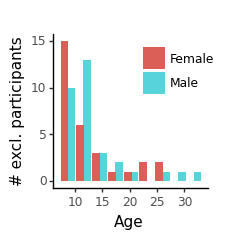

<ggplot: (116677516011)>


In [24]:
# Ages of excluded participants
excluded_ids = set([
    ID for ID in np.unique(rlwm.rl_IDs) if ID not in np.unique(all_data.ID)] + [
    ID for ID in np.unique(ps.ps_sID) if ID not in np.unique(all_data.ID)] + [
    ID for ID in np.unique(bf.bf_id) if ID not in np.unique(all_data.ID)
])
print("Number of excluded subjects: {}".format(len(excluded_ids)))

excluded_subj = ages.loc[ages.ID.isin(excluded_ids)]
excluded_subj['sex'] = excluded_subj.Gender.replace({1: 'Male', 2: 'Female'})
assert len(excluded_ids) == excluded_subj.shape[0]  # make sure every excluded participants is accounted for

gg.options.figure_size = (2, 2)
g = (gg.ggplot(excluded_subj, gg.aes('PreciseYrs', fill='sex'))
     + gg.geom_histogram(position=gg.position_dodge(width=2.5))
     + gg.theme(legend_position=(0.75, 0.75))
     + gg.labs(x='Age', y='# excl. participants', fill='')
)
g.save(os.path.join(plot_save_path, '0_ExcludedAges.png'))
print(g)

In [25]:
is_NaN = all_data[[c for c in all_data.columns if c not in ages_cols]].isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = all_data[row_has_NaN]
print("Number of rows with nans: {}".format(rows_with_NaN.shape[0]))
rows_with_NaN

Number of rows with nans: 5


,ID,bf_ACC,bf_ACC_early,bf_ACC_mid,bf_ACC_late,bf_RT,bf_RT_early,bf_RT_mid,bf_RT_late,bf_RTsd,...,T_group,T_group_,PDS_group,PDS_group_,bf_ACC_delta,bf_RT_delta,rl_ACC_delta,rl_RT_delta,ps_ACC_delta,ps_RT_delta
0,17,0.56667,0.65000,0.725,0.325,1.3395,1.2726,1.3378,1.4772,0.6963,...,NaN,NaN,0.67,2_mid,0.158438,0.281305,-0.259585,-1.199731,0.045938,-0.055572
1,18,0.80000,0.57500,0.875,0.950,1.1927,1.1396,1.2210,1.1988,0.5317,...,NaN,NaN,0.33,1_early,-0.285937,0.069217,-0.245001,-0.192427,-0.040000,-0.016628
10,35,0.85714,0.74359,0.925,0.900,2.2242,2.0274,2.4521,2.1484,1.4284,...,NaN,NaN,0.33,1_early,-0.128537,0.252636,-0.313332,-0.300120,0.031250,0.015044
20,55,0.84167,0.65000,0.875,1.000,1.9365,1.7065,2.3855,1.6931,1.3090,...,0.25,0_25%,NaN,NaN,-0.288750,-0.022777,-0.106666,0.411008,0.059062,-0.003000
61,120,0.58333,0.67500,0.600,0.475,1.5607,2.0898,1.2984,1.1403,1.3513,...,NaN,NaN,0.33,1_early,0.115000,-1.533490,-0.242085,-0.183179,0.017813,-0.006657


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\facets\facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\facets\facet.py:555: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 5 rows containing missing values.


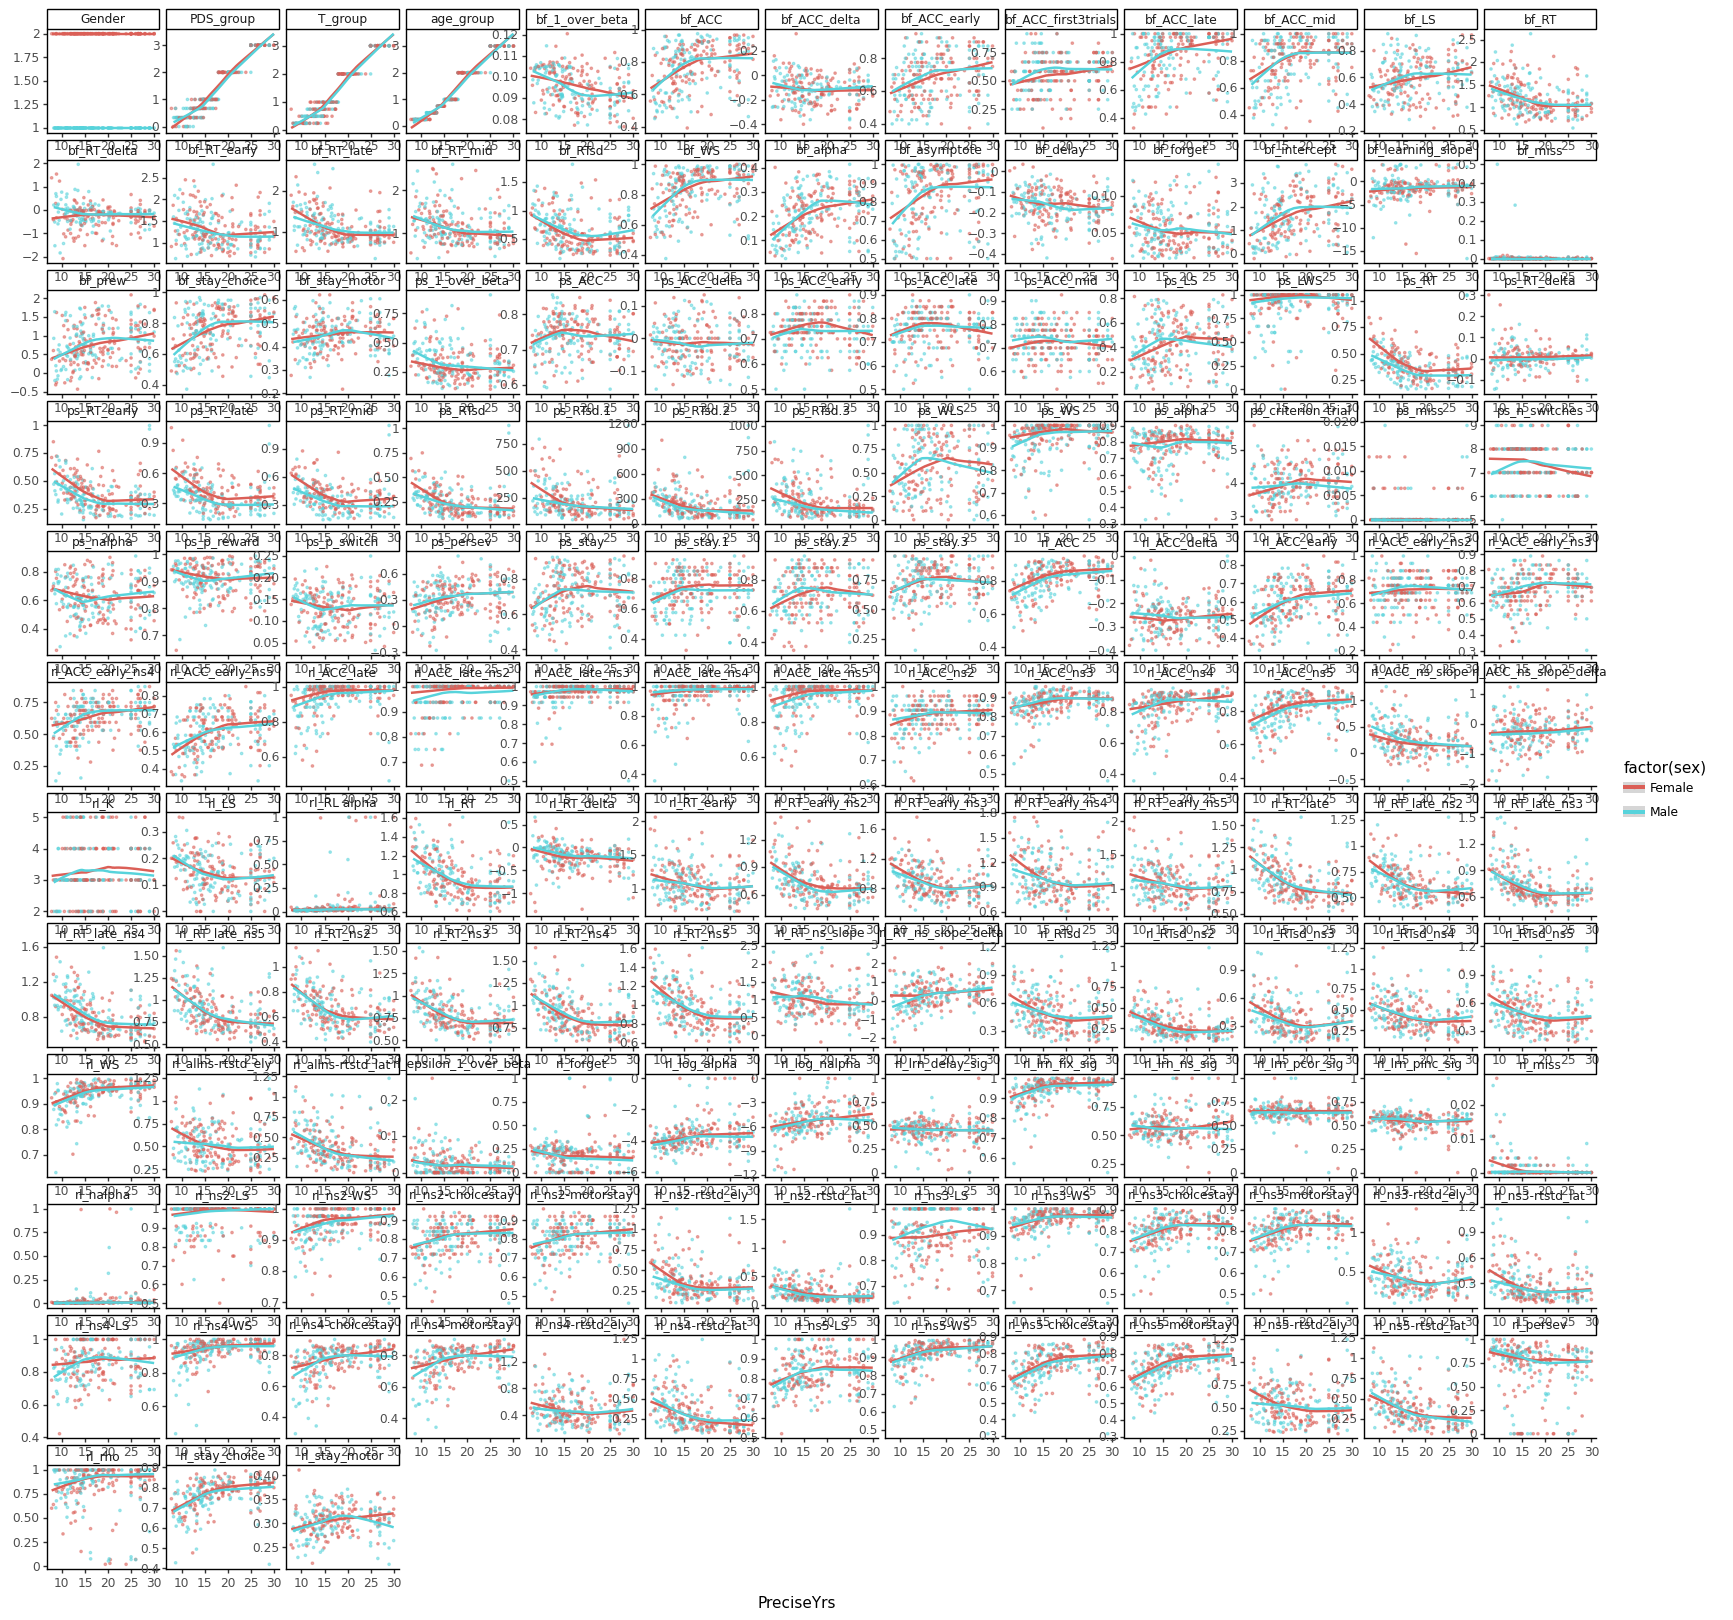

<ggplot: (116678110980)>

In [26]:
# Check that everything looks good
gg.options.figure_size = (20, 20)
all_data_long = all_data.melt(id_vars=ages_cols, var_name='feature')
g = (gg.ggplot(all_data_long, gg.aes('PreciseYrs', 'value', color='factor(sex)'))
 + gg.geom_point(size=0.5, alpha=0.5)
 + gg.geom_smooth()
 + gg.labs(y='')
 + gg.facet_wrap('~ feature', scales='free')
)
g